In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-test-data-sp24-npy/cifar10_test_data_sp24.npy


# Data Preprocessing

In [2]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import torch.utils.data as data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
transform = torchvision.transforms.ToTensor()

unprocessed_train_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True
)



arr_mean = np.mean(unprocessed_train_data.data, axis=(0, 1, 2)) / 255
arr_sd = np.std(unprocessed_train_data.data, axis=(0, 1, 2)) / 255

SIZE = 224


train_transforms = torchvision.transforms.Compose([
                           torchvision.transforms.Resize(SIZE),
                           torchvision.transforms.RandomRotation(5),
                           torchvision.transforms.RandomHorizontalFlip(0.5),
                           torchvision.transforms.RandomCrop(SIZE, padding=10),
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(mean=arr_mean,
                                                std=arr_sd)
                       ])

test_transforms = torchvision.transforms.Compose([
                           torchvision.transforms.Resize(SIZE),
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(mean=arr_mean,
                                                std=arr_sd)
                           ])
training_data = torchvision.datasets.CIFAR10(root = 'data',
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root = 'data',
                             train=False,
                             download=True,
                             transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 47144332.91it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )

In [5]:
train_data, val_data = data.random_split(training_data,
                                           [int(training_data.data.shape[0] * 0.9), int(training_data.data.shape[0] * 0.1)])


In [6]:
val_data = copy.deepcopy(val_data)
val_data.dataset.transform = test_transforms #make sure the val data uses test transform

# **Build Model Architecture**


In [7]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, output_dim),
        )
    

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

 
                
def design_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:

        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride = 2)]
        else:
        
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)
seq = [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]


# reference from https://pytorch.org/vision/0.8/_modules/torchvision/models/vgg.html

In [8]:
vgg1_layers = design_layers(seq, batch_norm=True)
model = VGG(vgg1_layers, 10)

In [9]:
BATCH_SIZE = 128

all_train_iterator = data.DataLoader(training_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)


train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)



In [10]:
all_train_iterator

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = model.to(device)
CEL = nn.CrossEntropyLoss().to(device)

In [12]:
device

device(type='cuda')

In [13]:
import torch.optim as optim


params = [
          {'params': model.features.parameters(), 'lr': 5e-4 / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=5e-4)


In [14]:
from tqdm.notebook import trange, tqdm

def train(model, iterator, optimizer, CEL, device):

    epoch_loss = 0
    epoch_accuracy = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = CEL(y_pred, y)

        accuracy = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)


def evaluate(model, iterator, CEL, device):

    epoch_loss = 0
    epoch_accuracy = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = CEL(y_pred, y)

            accuracy = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

    return epoch_loss / len(iterator), epoch_accuracy / len(iterator)

def calculate_accuracy(y_pred, y):
    first_pred = y_pred.argmax(1, keepdim=True)
    correct = first_pred.eq(y.view_as(first_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

  0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.021 | Train Acc: 33.29%
	 Val. Loss: 1.442 |  Val. Acc: 47.01%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 1.299 | Train Acc: 52.66%
	 Val. Loss: 1.132 |  Val. Acc: 58.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 1.046 | Train Acc: 62.32%
	 Val. Loss: 0.959 |  Val. Acc: 67.11%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 0.886 | Train Acc: 68.50%
	 Val. Loss: 0.830 |  Val. Acc: 70.74%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 0.767 | Train Acc: 73.22%
	 Val. Loss: 0.709 |  Val. Acc: 75.16%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 0.689 | Train Acc: 75.93%
	 Val. Loss: 0.666 |  Val. Acc: 76.88%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 0.642 | Train Acc: 77.61%
	 Val. Loss: 0.694 |  Val. Acc: 77.17%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 0.588 | Train Acc: 79.52%
	 Val. Loss: 0.627 |  Val. Acc: 79.71%


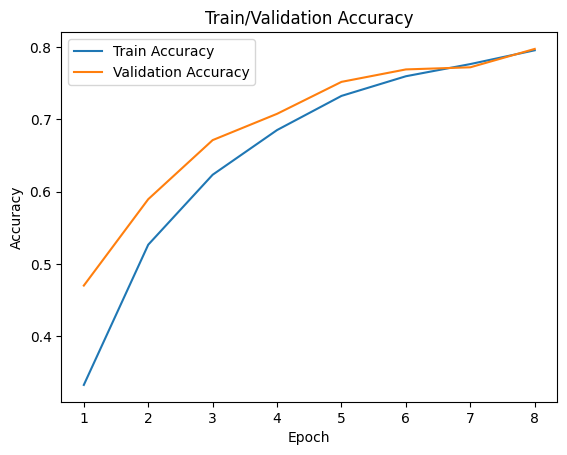

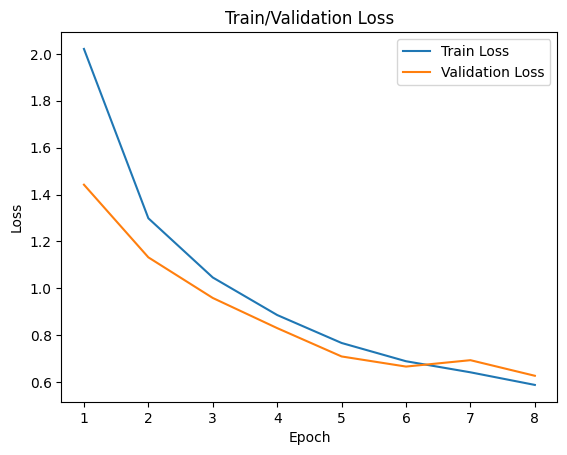

In [15]:
EPOCHS = 8

best_val_loss = float('inf')

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in trange(EPOCHS):

    train_loss, train_accuracy = train(model, train_iterator, optimizer, CEL, device)
    val_loss, val_accuracy = evaluate(model, val_iterator, CEL, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_accuracy*100:.2f}%')


plt.plot(range(1, EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy')
plt.legend()
plt.show()

plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()
plt.show()

In [16]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("/kaggle/input/cifar10-test-data-sp24-npy/cifar10_test_data_sp24.npy"), "You must upload the test data to the file system."
        self.data = [np.load("/kaggle/input/cifar10-test-data-sp24-npy/cifar10_test_data_sp24.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=test_transforms # NOTE: Make sure transform is the same as used in the training dataset.
)

test_data = torchvision.datasets.CIFAR10(root = 'data',
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified


In [17]:
test_iterator = data.DataLoader(testing_data,
                                batch_size=BATCH_SIZE,
                               shuffle = False)


In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [19]:


def get_predictions(model, iterator):

    model.eval()
    model = model.to(device)
    labels = []

    with torch.no_grad():
        for x in tqdm(iterator):
            x = x.to(device)

            y_pred, _ = model(x)
            
            _, predicted_labels = torch.max(y_pred, 1)
            
            labels.extend(predicted_labels.tolist())
    

    return labels


predictions = get_predictions(model, test_iterator)
len(predictions)

  0%|          | 0/79 [00:00<?, ?it/s]

10000

In [20]:
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('submission.csv', index_label='Id')